# Project 2 - Coronavirus

This project consist to estimate the SIR model with the most updated data from WHO.

In [10]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt

In [11]:
import PDEparams as pde

## Data from World Health Organization
#### Only laboratory-confirmed, exclude clinically diagnose

In [12]:
data = pd.read_csv('CoV2019.csv')
china = data["China"][:27]#data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]

### Ploting raw data

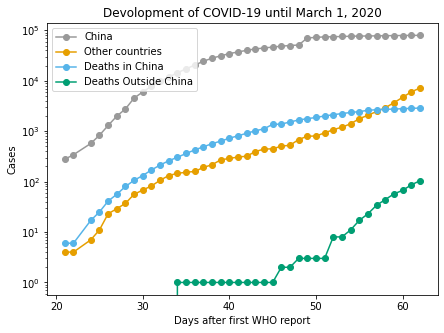

In [52]:
plt.figure(figsize=(7, 5))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()
plt.show()

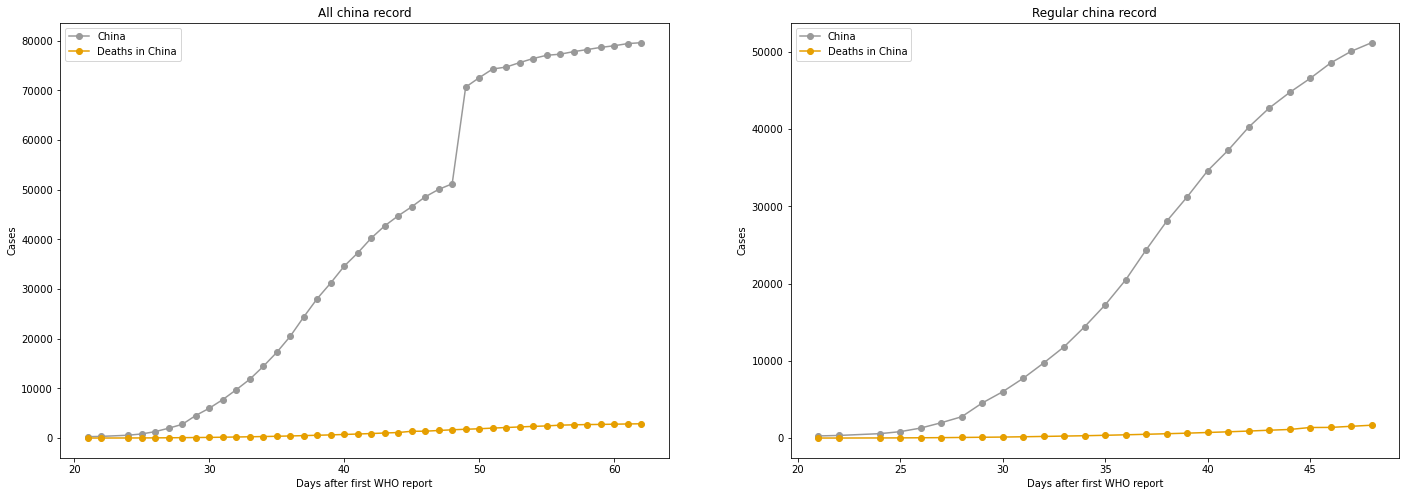

In [56]:
plt.figure(figsize=(24, 8))

plt.subplot(1,2,1)
plt.title("All china record")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()


plt.subplot(1,2,2)
plt.title("Regular china record")
plt.plot(days, china, '-o', label="China")
plt.plot(days, deaths_china, '-o', label="Deaths in China")
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()
plt.show()

plt.show()

### Defining the model

We use a SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

### Initial Conditions

In [24]:
Hubei = 5917*10**4
Guangdong = 11346*10**4
Henan = 9605*10**4
Zhejiang = 5737*10**4
Hunan = 6899*10**4
Anhui = 6324*10**4
Jiangxi = 4648*10**4
Wuhan = 11.08e6
N = 56*10**3                        # estimate of people affected by lock down
init_I = 1
init_R = 1

### Approach

We want to know how the population is gona be affected by the pandemi. So by the supposing the pandemic follow a ISR model then we will explore the future of this trends.

First, we will use the PDEparams library to have an approx of parameters. To simplfy the data notice how 

$$
\frac{\mathrm{d} S}{\mathrm{d} t} + \frac{\mathrm{d} R}{\mathrm{d} t} +\frac{\mathrm{d} I}{\mathrm{d} t} = 0
 $$
 
 That means the amount of populations is constant over the days, say a population $N$. And $N=S+I+R$. So we can reduce our system of equations by changing $S = N - (I+R)$. Now the system is:
 
$$\begin{align}
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{\left( N - (I+R)\right)I}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Now the problem is in terms of the number of cases and the number of deaths.

## Using PDEparams library

In [23]:
#Setting data
dataPDE = data[["Days","China","Death China"]].iloc[:21,:]
dataPDE = dataPDE.rename(columns={"Days": "0", "China": "1","Death China":"2"})
dataPDE.head()

,0,1,2
0,21,278,6
1,22,341,6
2,24,571,17
3,25,830,25
4,26,1297,41


In [25]:
#Setting model
def SIR(z, t, b, g):
    '''The input z corresponds to the current state of the system, z = [x, y]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    b and g correspond to the unknown parameters.
    '''
    
    I, R = z
    
    return [b*(N-(I+R))*I/N-g*I, g*I]


#Initial values

def initial_x():
    return init_I

def initial_y():
    return init_R

In [42]:
my_model = pde.PDEmodel(dataPDE, SIR, [initial_x, initial_y], bounds=[(0, 1), (0,0.01)], #El bound superior de gamma se escogio para que se aprecie en el profile porque es la mejor opción se trato primero con 1 y 0.1
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=2, ndims=0, nreplicates=1, obsidx=None, outfunc=None)


In [43]:
my_model.initial_condition

array([1, 1])

In [44]:
my_model.fit()

    $\beta$  $\gamma$
0  0.294979  0.006194


In [45]:
my_model.best_params

,$\beta$,$\gamma$
0,0.294979,0.006194


In [46]:
my_model.best_error

242497.15284418542

In [47]:
my_model.likelihood_profiles()

parameters:   0%|          | 0/2 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


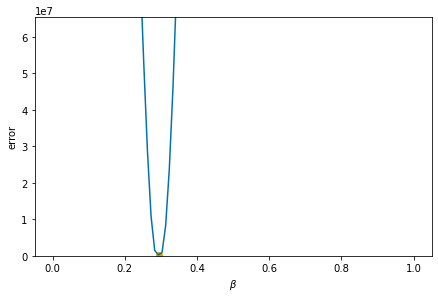

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


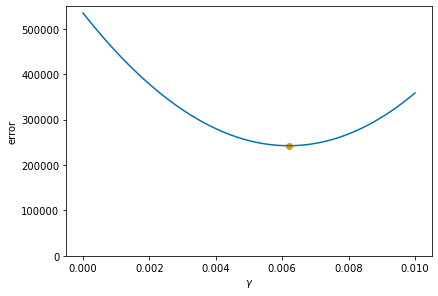

In [48]:
my_model.plot_profiles()

Checando los resultados

In [77]:
t = np.arange(0,70,1)
beta = 0.294979
gamma = 0.006194

sol = odeint(SIR, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma #gamma
                  )
            )

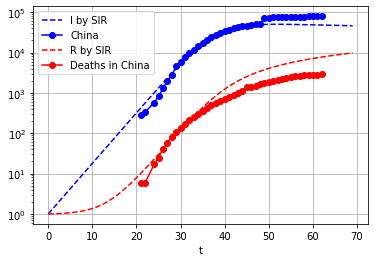

In [78]:
plt.plot(t, sol[:, 0], 'b--', label='I by SIR')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol[:, 1], 'r--', label='R by SIR')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")

plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()

In [ ]:
mean_squared_error()

--------

Ahora vamos a estimar la $N$ nosotros

In [86]:
#Setting model
def SIR_N(z, t, b, g, Ni):
    '''The input z corresponds to the current state of the system, z = [x, y]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    b and g correspond to the unknown parameters.
    '''
    
    I, R = z
    
    return [b*(Ni-(I+R))*I/Ni-g*I, g*I]


#Initial values

def initial_x():
    return init_I

def initial_y():
    return init_R

my_model2 = pde.PDEmodel(dataPDE, SIR_N, [initial_x, initial_y], bounds=[(0, 1), (0,0.01),(1e3,1e5)], 
                        param_names=[r'$\beta$', r'$\gamma$', r'N'], nvars=2, ndims=0, nreplicates=1, obsidx=None, outfunc=None)




In [87]:
my_model2.fit()

    $\beta$  $\gamma$             N
0  0.295009  0.003613  50985.428483


In [88]:
my_model2.best_error

72802.8634751579

In [89]:
my_model2.best_params

,$\beta$,$\gamma$,N
0,0.295009,0.003613,50985.428483


In [90]:
my_model2.likelihood_profiles()

parameters:   0%|          | 0/3 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

values within parameters:   0%|          | 0/100 [00:00<?, ?it/s]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


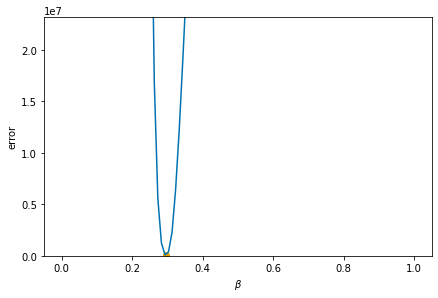

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


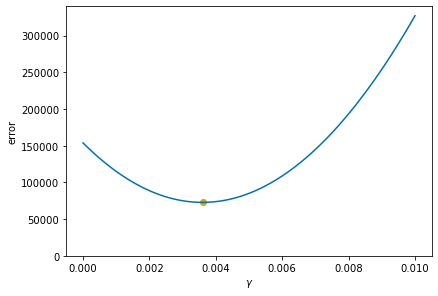

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


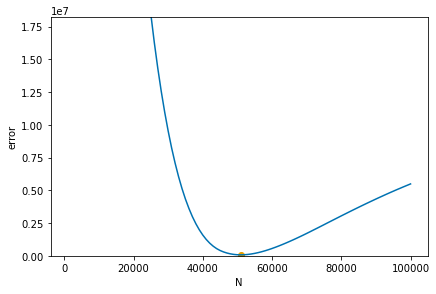

In [91]:
my_model2.plot_profiles()

Checando resultados

In [92]:
t = np.arange(0,60,1)
beta = 0.295009
gamma = 0.003613
Ni = 50985.428483

sol = odeint(SIR_N, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma, #gamma
                   Ni
                  )
            )

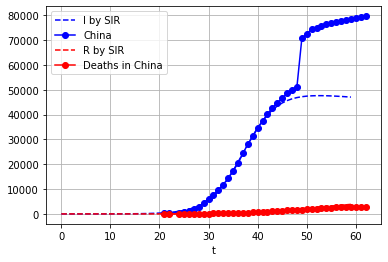

In [94]:
plt.plot(t, sol[:, 0], 'b--', label='I by SIR')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol[:, 1], 'r--', label='R by SIR')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")


plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()

----

## Using all data

In [95]:
my_model3 = pde.PDEmodel(data[["Days","China","Death China"]],
                         SIR,
                         [initial_x, initial_y],
                         bounds=[(0, 1), (0,0.01)], #El bound superior de gamma se escogio para que se aprecie en el profile porque es la mejor opción se trato primero con 1 y 0.1
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=2, ndims=0, nreplicates=1, obsidx=None, outfunc=None)



In [96]:
my_model3.fit()

    $\beta$  $\gamma$
0  0.289113       0.0


In [97]:
t = np.arange(0,70,1)
beta = 0.289113
gamma = 0.0

sol3 = odeint(SIR, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma #gamma
                  )
            )


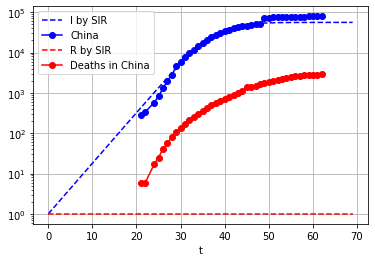

In [98]:
plt.plot(t, sol3[:, 0], 'b--', label='I by SIR')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol3[:, 1], 'r--', label='R by SIR')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")

plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()

## Solving the given ODE

In [49]:
from scipy.integrate import odeint

In [56]:
t = np.arange(0,70,1)
beta = 2.03353167e-01
gamma = 1.12502561e-02
Np = 1.46228381e+06

sol = odeint(SIR, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma, #gamma
                   Np) # N
            )

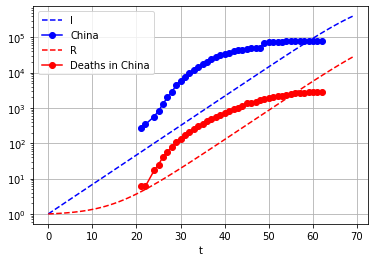

In [75]:
plt.plot(t, sol[:, 0], 'b--', label='I')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol[:, 1], 'r--', label='R')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")

plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()

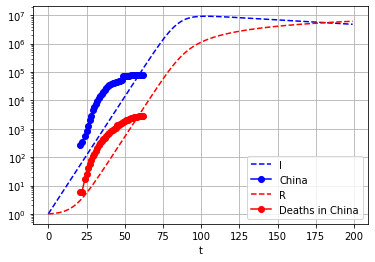

In [129]:
t = np.arange(0,200,1)
beta = 0.197809
gamma = 0.007265
Np = 11.08e+06

sol = odeint(SIR, #model
             [init_I,init_R], #init conditions
             t, #times
             args=(beta, #beta
                   gamma, #gamma
                   Np) # N
            )

plt.plot(t, sol[:, 0], 'b--', label='I')

plt.plot(days_total, china_total, 'b-o', label="China")

plt.plot(t, sol[:, 1], 'r--', label='R')

plt.plot(days_total, deaths_china_total, 'r-o', label="Deaths in China")

plt.yscale('log')

plt.legend(loc='best')

plt.xlabel('t')

plt.grid()

plt.show()